# Distances Test

In [1]:
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [15]:
import numpy as np
from scipy.spatial import distance
from sklearn.preprocessing import normalize

from tqdm.auto import tqdm
import pickle
import gc
import json
import h5py
import pandas as pd

from IPython.display import clear_output
import matplotlib.pyplot as plt
%matplotlib inline

def load_file(path, name):
    import importlib.util
    spec = importlib.util.spec_from_file_location(name, path)
    mod = importlib.util.module_from_spec(spec)
    spec.loader.exec_module(mod)
    return mod

models = load_file("../../utils/models.py", "models")
data = load_file("../../utils/data.py", "data")
plot = load_file("../../utils/plot.py", "plot")

cuda = torch.device('cuda')
frame_size = 10
# https://drive.google.com/open?id=1xjVI4uVQGsQ7tjOJ3594ZXmAEC_6yX0e
meta = json.load(open('../../data/metadata.json'))
tqdm.pandas()

In [3]:
# https://drive.google.com/open?id=1kTyu05ZmtP2MA33J5hWdX8OyUYEDW4iI
movie_ref = pickle.load(open('../../data/infos_pca128.pytorch', 'rb'))
movie_ref_tensor, key_to_id, id_to_key = data.make_movie_tensor(movie_ref)
# download ml20m dataset yourself
ratings = pd.read_csv('../../data/ml-20m/ratings.csv')
user_dict, users = data.prepare_tensor(ratings, key_to_id, frame_size)
del ratings
gc.collect()
clear_output(True)
clear_output(True)
print('Done!')

Done!


In [5]:
ddpg = models.Actor(1290, 128, 256).to(cuda)
td3 = models.Actor(1290, 128, 256).to(cuda)
perturbator = models.bcqPerturbator(1290, 128, 256).to(cuda)
generator = models.bcqGenerator(1290, 128, 512).to(cuda)
ddpg.load_state_dict(torch.load('../../models/DDPG/ddpg_policy.pt'))
td3.load_state_dict(torch.load('../../models/TD3/td3_policy_1.pt'))
perturbator.load_state_dict(torch.load('../../models/BCQ/bcq_policy.pt'))
generator.load_state_dict(torch.load('../../models/BCQ/bcq_vae.pt'))


<All keys matched successfully>

In [6]:
test_users = users[-5000:]
batch_size = 25

def prepare_batch_wrapper(x):
    batch = data.prepare_batch(x, movie_ref_tensor, frame_size=frame_size)
    return batch

test_user_dataset = data.UserDataset(test_users, user_dict)
test_dataloader = DataLoader(test_user_dataset, batch_size=batch_size,
                        shuffle=True, num_workers=4,collate_fn=prepare_batch_wrapper)
test_batch = next(iter(test_dataloader))
state = test_batch[0].to(cuda)

In [7]:
def rank(gen_action, metric):
    scores = []
    for i in movie_ref.keys():
        scores.append([i, metric(movie_ref[i], gen_action)])
    scores = list(sorted(scores, key = lambda x: x[1]))
    scores = scores[:10]
    ids = [i[0] for i in scores]
    dist = [i[1] for i in scores]

    return ids, dist

In [8]:
import faiss
# test indexes
indexL2 = faiss.IndexFlatL2(128)
indexIP = faiss.IndexFlatIP(128)
indexCOS = faiss.IndexFlatIP(128)

mov_mat  = np.stack(movie_ref.values()).astype('float32')
indexL2.add(mov_mat)
indexIP.add(mov_mat)
indexCOS.add(normalize(mov_mat, axis=1, norm='l2'))


def query(index, action, k=20):
    D, I = index.search(action, k)
    return D, I

/home/dev/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  import sys


In [10]:
ddpg_action = ddpg(state)
ddpg_action = ddpg_action[np.random.randint(0, state.size(0), 50)].detach().cpu().numpy() 
td3_action = td3(state)
td3_action = td3_action[np.random.randint(0, state.size(0), 50)].detach().cpu().numpy() 
sampled_actions = generator.decode(state)
perturbed_actions= perturbator(state, sampled_actions)
bcq_action = perturbed_actions[np.random.randint(0, state.size(0), 50)].detach().cpu().numpy()

## Euclidean L2 Distance

In [11]:
def get_err_l2_dist(action, k=5):
    D, I = query(indexL2, action)
    D = D ** 0.5 # l2 -> euclidean
    mean = D.mean(axis=1).mean()
    std  = D.std(axis=1).mean()
    return I, mean, std

In [12]:
ddpg_I, ddpg_mean, ddpg_std = get_err_l2_dist(ddpg_action, 10)
td3_I, td3_mean, td3_std = get_err_l2_dist(td3_action, 10)
bcq_I, bcq_mean, bcq_std = get_err_l2_dist(bcq_action, 10)

labels = ['DDPG', 'TD3', 'BCQ']
x_pos = np.arange(len(labels))
CTEs = [ddpg_mean, td3_mean, bcq_mean]
error = [ddpg_std, td3_std, bcq_std]

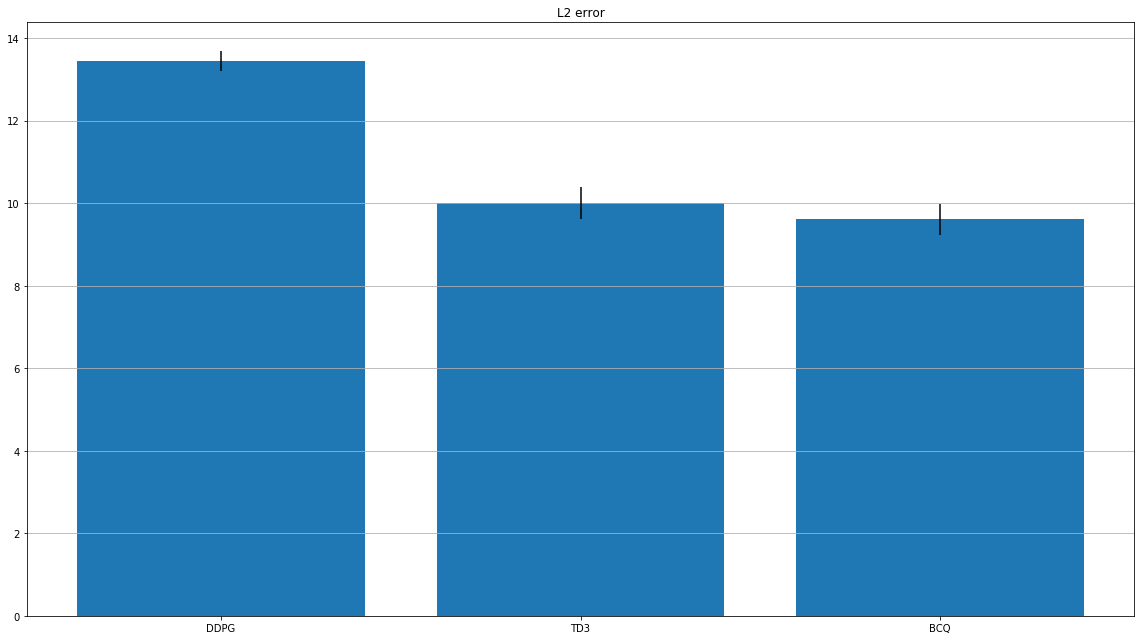

In [13]:
fig, ax = plt.subplots(figsize=(16, 9))
ax.bar(x_pos, CTEs,yerr=error,)
ax.set_xticks(x_pos)
ax.set_xticklabels(labels)
ax.set_title('L2 error')
ax.yaxis.grid(True)

# Save the figure and show
plt.tight_layout()
plt.show()

### Recommended movie similarities

/home/dev/anaconda3/lib/python3.7/site-packages/matplotlib/figure.py:445: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  % get_backend())


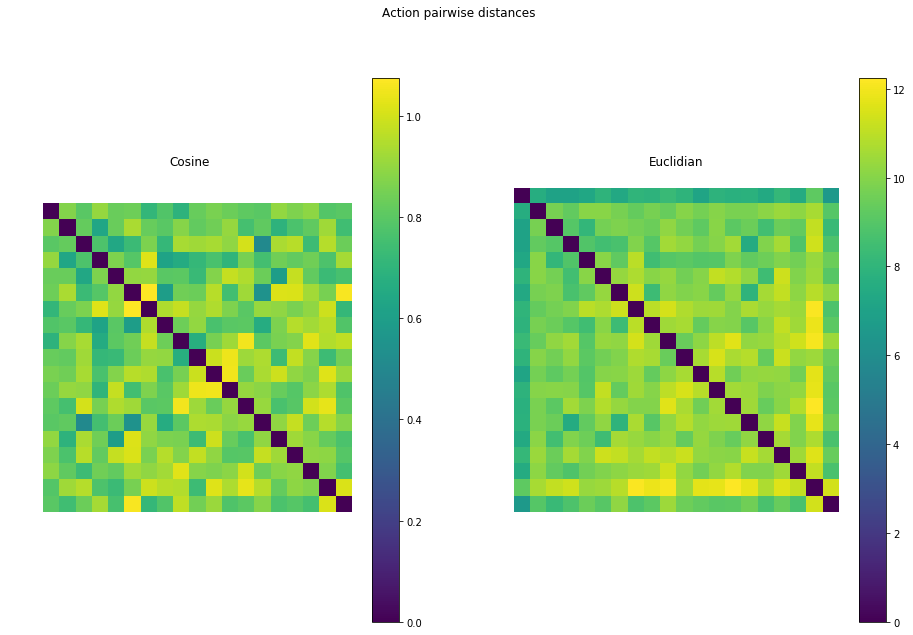

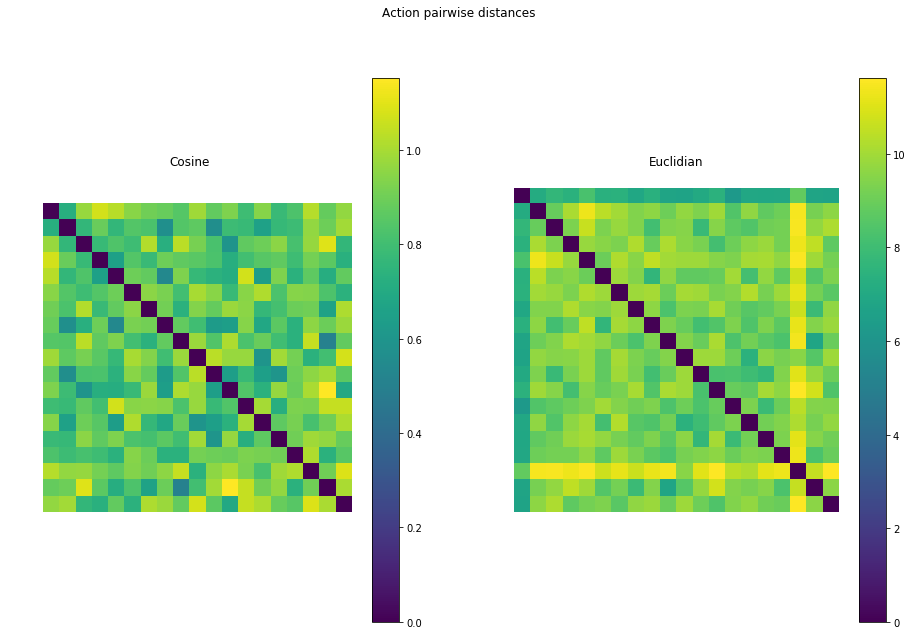

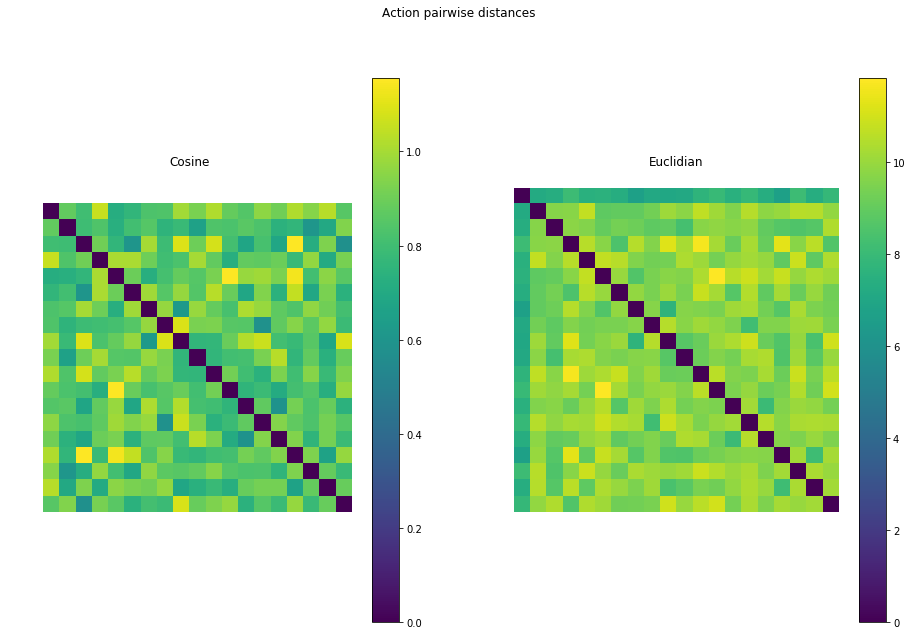

In [16]:
action = np.random.randint(0, 50, 1)[0]

plot.embed_show(torch.tensor(mov_mat[ddpg_I][action]))
plot.embed_show(torch.tensor(mov_mat[td3_I][action]))
plot.embed_show(torch.tensor(mov_mat[bcq_I][action]))

## InnerProduct Distance
### bigger = better

In [17]:
def get_err_ip_dist(action, k=5):
    D, I = query(indexIP, action)
    mean = D.mean(axis=1).mean()
    std  = D.std(axis=1).mean()
    return mean, std

In [18]:
ddpg_mean, ddpg_std = get_err_ip_dist(ddpg_action, 10)
td3_mean, td3_std = get_err_ip_dist(td3_action, 10)
bcq_mean, bcq_std = get_err_ip_dist(bcq_action, 10)

labels = ['DDPG', 'TD3', 'BCQ']
x_pos = np.arange(len(labels))
CTEs = [ddpg_mean, td3_mean, bcq_mean]
error = [ddpg_std, td3_std, bcq_std]

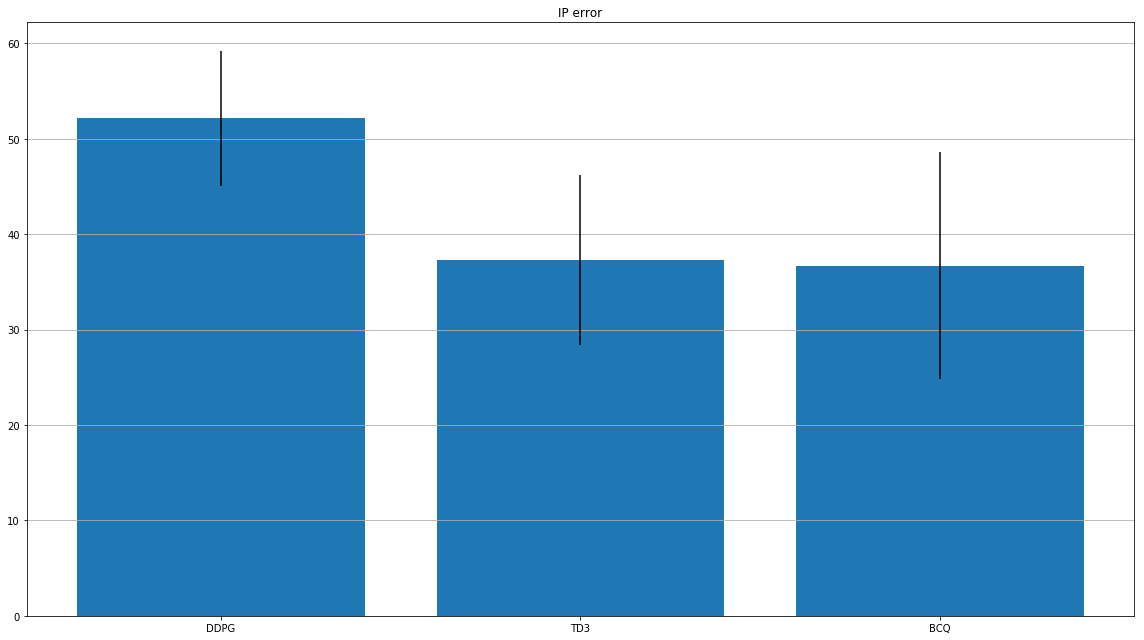

In [19]:
fig, ax = plt.subplots(figsize=(16, 9))
ax.bar(x_pos, CTEs,yerr=error,)
ax.set_xticks(x_pos)
ax.set_xticklabels(labels)
ax.set_title('IP error')
ax.yaxis.grid(True)

# Save the figure and show
plt.tight_layout()
plt.show()

## Cosine Distance

In [20]:
def get_err_cos_dist(action, k=5):
    action = normalize(action, axis=1, norm='l2')
    D, I = query(indexCOS, action)
    mean = D.mean(axis=1).mean()
    std  = D.std(axis=1).mean()
    return I, mean, std

In [21]:
# normalization test
np.allclose(np.linalg.norm(normalize(ddpg_action, axis=1, norm='l2'), axis=1), 1)

True

In [22]:
ddpg_I, ddpg_mean, ddpg_std = get_err_cos_dist(ddpg_action, 10)
td3_I, td3_mean, td3_std = get_err_cos_dist(td3_action, 10)
bcq_I, bcq_mean, bcq_std = get_err_cos_dist(bcq_action, 10)

labels = ['DDPG', 'TD3', 'BCQ']
x_pos = np.arange(len(labels))
CTEs = [ddpg_mean, td3_mean, bcq_mean]
error = [ddpg_std, td3_std, bcq_std]

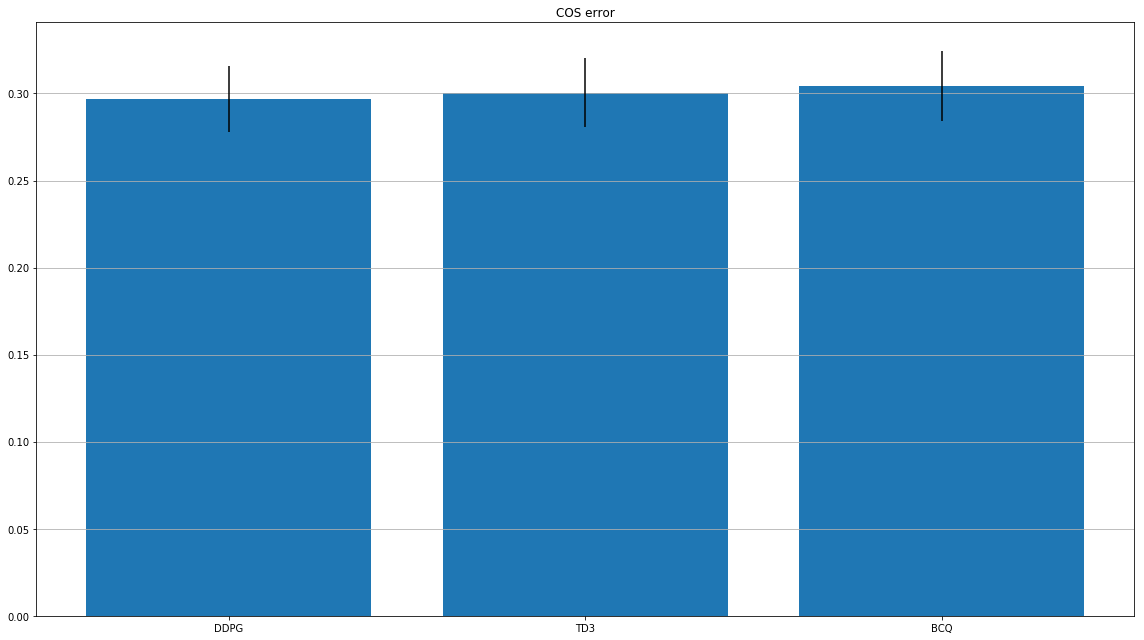

In [23]:
fig, ax = plt.subplots(figsize=(16, 9))
ax.bar(x_pos, CTEs,yerr=error,)
ax.set_xticks(x_pos)
ax.set_xticklabels(labels)
ax.set_title('COS error')
ax.yaxis.grid(True)

# Save the figure and show
plt.tight_layout()
plt.show()

### Recommended movies similarities

/home/dev/anaconda3/lib/python3.7/site-packages/matplotlib/figure.py:445: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  % get_backend())


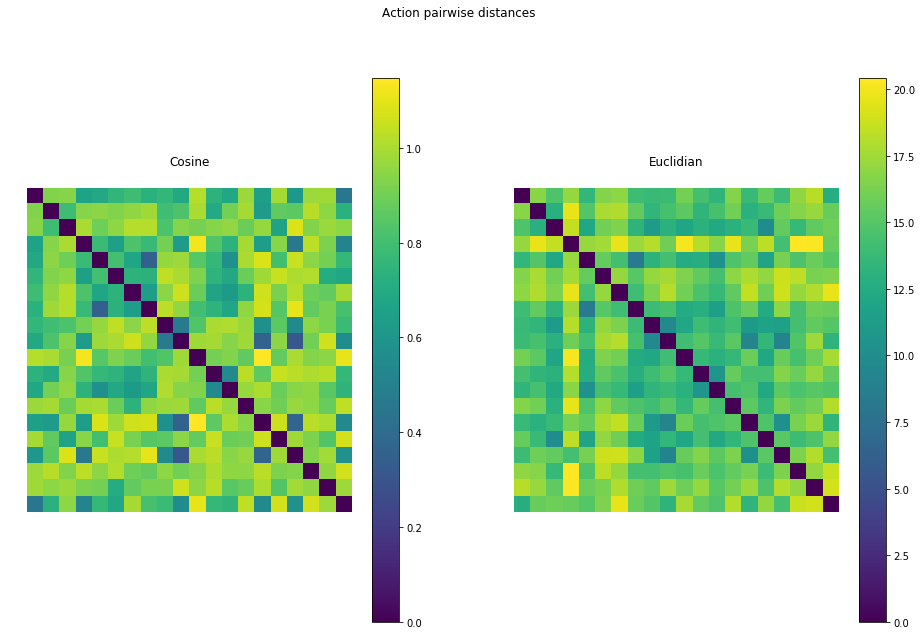

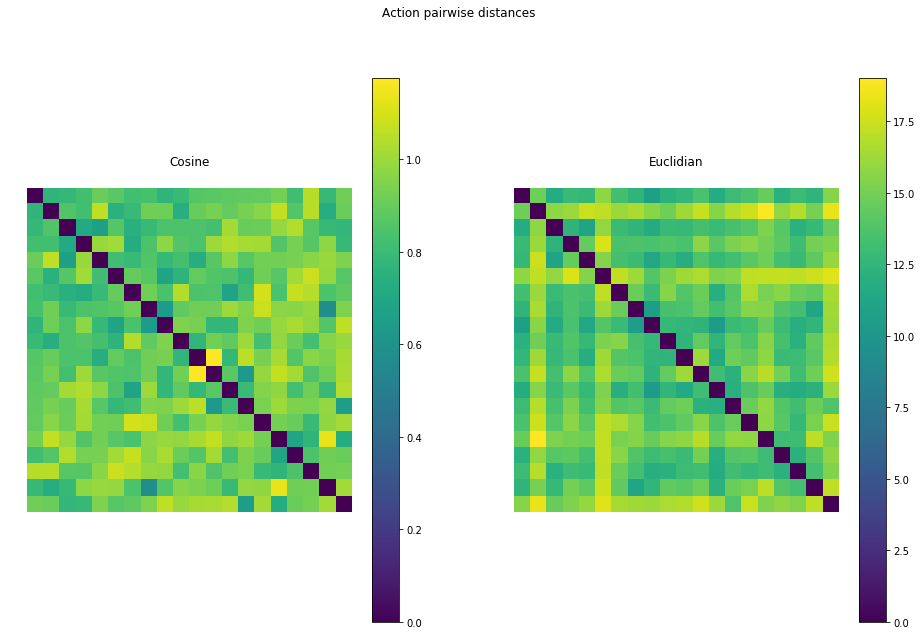

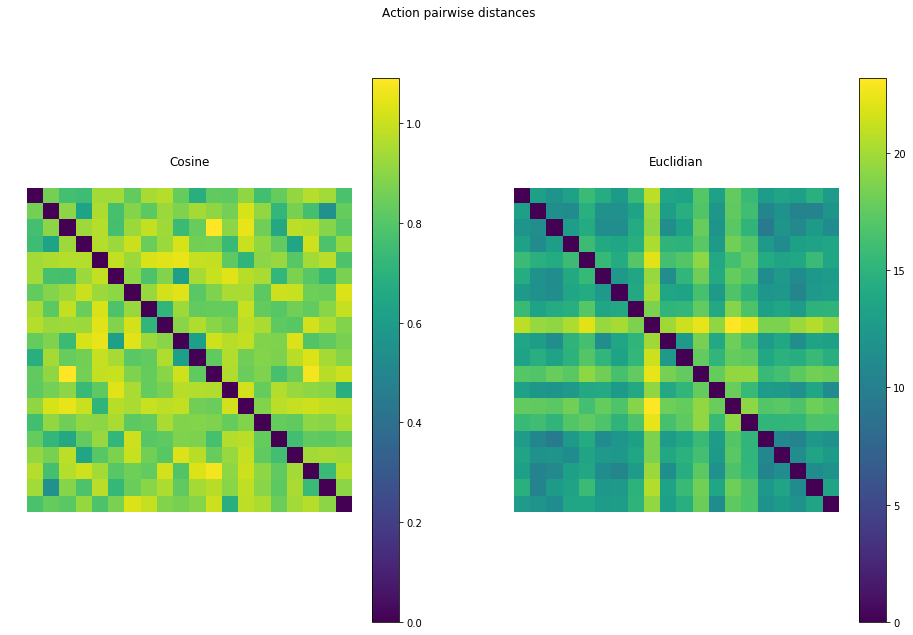

In [24]:
action = np.random.randint(0, 50, 1)[0]

plot.embed_show(torch.tensor(mov_mat[ddpg_I][action]))
plot.embed_show(torch.tensor(mov_mat[td3_I][action]))
plot.embed_show(torch.tensor(mov_mat[bcq_I][action]))